<a href="https://colab.research.google.com/github/RutwikP/Generalizing-Cardiac-Image-Segmentation-/blob/main/Generalizing_Cardiac_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install SimpleITK

     |████████████████████████████████| 47.4MB 61kB/s 


In [ ]:
pip install nibabel


In [ ]:
pip install itkwidgets

     |████████████████████████████████| 3.4MB 7.8MB/s 
     |████████████████████████████████| 68.0MB 66kB/s 
     |████████████████████████████████| 112kB 58.9MB/s 
     |████████████████████████████████| 1.6MB 48.9MB/s 
     |████████████████████████████████| 2.2MB 48.0MB/s 
     |████████████████████████████████| 50.1MB 53kB/s 
     |████████████████████████████████| 593kB 48.3MB/s 
     |████████████████████████████████| 276kB 45.5MB/s 
     |████████████████████████████████| 36.3MB 66kB/s 


In [ ]:
# Import all the necessary packages
import numpy as np
import nibabel as nib                                                     # Read / write access to some common neuroimaging file formats
import itk                                                                # Jupyter widgets to visualize images in 2D and 3D
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt

%matplotlib inline


In [ ]:
import pandas as pd
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import SimpleITK as sitk
import glob
import matplotlib.pyplot as plt
import numpy as np
import random


import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

import pickle

In [ ]:
# All Functions

def resample_image(itk_image, out_spacing=(1.0, 1.0, 1.5), is_label=False):
    original_spacing = itk_image.GetSpacing()
    original_size    = itk_image.GetSize()

    #print(original_size[0], original_spacing[0], out_spacing[0], 128, original_size[0]*(original_spacing[0]))
    
    out_size = [int(np.round(original_size[0]*(original_spacing[0]/out_spacing[0]))),
                int(np.round(original_size[1]*(original_spacing[1]/out_spacing[1]))),
                int(np.round(original_size[2]*(original_spacing[2]/out_spacing[2])))]
    #print(out_size)
    #out_size = [128, 128, 128]
    resample = sitk.ResampleImageFilter()
    #resample.SetNumberOfThreads(1)
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(0)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        #resample.SetInterpolator(sitk.sitkBSpline)
        resample.SetInterpolator(sitk.sitkLinear)

    return resample.Execute(itk_image)

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            #nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            #nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
class SUNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(SUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        #self.out_softmax = nn.LogSoftmax(dim=1)
        
        self.gn1 = nn.GroupNorm(8, 16)
        self.gn2 = nn.GroupNorm(16, 32)
        self.gn3 = nn.GroupNorm(32, 64)
        self.gn4 = nn.GroupNorm(64, 128)
        self.gn5 = nn.GroupNorm(32, 64)
        self.gn6 = nn.GroupNorm(16, 32)
        self.gn7 = nn.GroupNorm(8, 16)
    
    def forward(self, x):
        x1 = self.inc(x)
        x1 = self.gn1(x1)
       
        x2 = self.down1(x1)
        x2 = self.gn2(x2)
       
        x3 = self.down2(x2)
        x3 = self.gn3(x3)
       
        x4 = self.down3(x3)
        x4 = self.gn4(x4)
       
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.gn5(x)
       
        x = self.up2(x, x3)
        x = self.gn6(x)
       
        x = self.up3(x, x2)
        x = self.gn7(x)
       
        x = self.up4(x, x1)
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

#model = SUNet(1, 1)
#model.cuda()

In [ ]:
# For creating the numpy array of Training Set

pkl_file = open('/content/gdrive/MyDrive/MandM1/file_hash.pkl', 'rb')
file_hash = pickle.load(pkl_file)
pkl_file.close()

a = glob.glob('/content/gdrive/MyDrive/MandM1/*_sa.nii.gz')
print(len(a))

trainx = []
trainy = []

150


In [ ]:
count = 0
for t in a:
    hash_result = file_hash[str(t.split('/')[-1].split('_')[0])]
    if hash_result[0] == 'B':
        vol_img  = sitk.ReadImage(t)
        mask_img = sitk.ReadImage(t.replace('_sa.nii.gz', '_sa_gt.nii.gz'))
        
        vol     = sitk.GetArrayFromImage(vol_img)
        mask    = sitk.GetArrayFromImage(mask_img)
        
        vol  = vol[hash_result[2]]
        mask = mask[hash_result[2]]
        
        mask_img1 = sitk.GetImageFromArray(mask)
        mask_img1.SetSpacing(mask_img.GetSpacing()[:3])
        
        vol_img1  = sitk.GetImageFromArray(vol)
        vol_img1.SetSpacing(mask_img.GetSpacing()[:3])
        
      
        vol_img2  =  resample_image(vol_img1, (2, 2, 2))
        mask_img2 =  resample_image(mask_img1, (2, 2, 2), is_label=True)
        
        vol  = sitk.GetArrayFromImage(vol_img2)
        mask = sitk.GetArrayFromImage(mask_img2)
        
        print(count, t.split('/')[-1].split('_')[0], hash_result, vol_img2.GetSize(), mask_img2.GetSize())
        
        for k in range(mask.shape[0]):
            if np.count_nonzero(mask[k].flatten()) > 0:
                temp = vol[k]
                midy = int(temp.shape[1]/2)
                sz = sy  = np.max([0,   midy-80])
                ez = ey  = np.min([160, midy+80])
                temp = temp[sy:sy+160, sz:sz+160]
                
                temp1 = mask[k]
                temp1 = temp1[sy:sy+160, sz:sz+160]
                
                sx = np.max(int((160-temp.shape[0])/2), 0)
                sy = np.max(int((160-temp.shape[1])/2), 0)

                temp = np.pad(temp, ((sx, 160-temp.shape[0]-sx), (sy, 160-temp.shape[1]-sy)), 'constant')
                trainx.append(np.expand_dims(temp, 0)/1024.0)
                
                temp1 = np.pad(temp1, ((sx, 160-temp1.shape[0]-sx), (sy, 160-temp1.shape[1]-sy)), 'constant')
                trainy.append(np.expand_dims(temp1, 0))
                #print(temp.shape, temp1.shape)
                #print(temp.shape)
                #trainx.append(vol[k])
                #trainy.append(mask[k])
        
        count = count+1
        
# trainx = np.array(trainx)
# trainy = np.array(trainy)


# valx = trainx[int(trainx.shape[0]*0.8):]
# valy = trainy[int(trainy.shape[0]*0.8):]

# trainx = trainx[:int(trainx.shape[0]*0.8)]
# trainy = trainy[:int(trainy.shape[0]*0.8)]


# print(trainx.shape, trainy.shape)
# print(valx.shape,   valy.shape)

0 A1D0Q7 ['B', 2, 0, 9] (189, 189, 50) (189, 189, 50)
1 A7G0P5 ['B', 2, 28, 9] (189, 189, 50) (189, 189, 50)
2 A9J8W7 ['B', 2, 29, 10] (189, 189, 50) (189, 189, 50)
3 B3D0N1 ['B', 3, 24, 8] (190, 190, 60) (190, 190, 60)
4 B9O1Q0 ['B', 2, 29, 11] (189, 189, 55) (189, 189, 55)
5 C3I2K3 ['B', 2, 29, 11] (211, 211, 50) (211, 211, 50)
6 A9C5P4 ['B', 2, 29, 8] (197, 197, 50) (197, 197, 50)
7 B2D9O2 ['B', 2, 29, 13] (189, 189, 50) (189, 189, 50)
8 A3B7E5 ['B', 2, 29, 12] (189, 189, 50) (189, 189, 50)
9 A6M1Q7 ['B', 2, 29, 11] (189, 189, 50) (189, 189, 50)
10 A9E3G9 ['B', 3, 23, 8] (214, 214, 50) (214, 214, 50)
11 C4R8T7 ['B', 2, 28, 8] (189, 189, 50) (189, 189, 50)
12 D1L4Q9 ['B', 2, 29, 10] (189, 189, 55) (189, 189, 55)
13 B2F4K5 ['B', 2, 29, 10] (211, 211, 50) (211, 211, 50)
14 D6H6O2 ['B', 2, 29, 9] (189, 189, 40) (189, 189, 40)
15 E4W8Z7 ['B', 2, 29, 10] (211, 211, 50) (211, 211, 50)
16 A9J5Q7 ['B', 3, 24, 7] (190, 190, 50) (190, 190, 50)
17 C2L5P7 ['B', 2, 28, 12] (189, 189, 50) (189, 18

In [ ]:
trainx = np.array(trainx) # for B
trainy = np.array(trainy) # for B


valx = trainx[int(trainx.shape[0]*0.8):] # for B
valy = trainy[int(trainy.shape[0]*0.8):] # for B

trainx = trainx[:int(trainx.shape[0]*0.8)] # for B
trainy = trainy[:int(trainy.shape[0]*0.8)] # for B


print(trainx.shape, trainy.shape) # for B
print(valx.shape,   valy.shape)   # for B

(2520, 1, 160, 160) (2520, 1, 160, 160)
(631, 1, 160, 160) (631, 1, 160, 160)


In [ ]:
trainx_A = []
trainy_A = []
count_A = 0
for j in a:
    hash_result_A = file_hash[str(j.split('/')[-1].split('_')[0])]
    if hash_result_A[0] == 'A':
        vol_img_A  = sitk.ReadImage(j)
        mask_img_A = sitk.ReadImage(j.replace('_sa.nii.gz', '_sa_gt.nii.gz'))
        
        vol_A     = sitk.GetArrayFromImage(vol_img_A)
        mask_A    = sitk.GetArrayFromImage(mask_img_A)
        
        vol_A  = vol_A[hash_result_A[2]]
        mask_A = mask_A[hash_result_A[2]]
        
        mask_img1_A = sitk.GetImageFromArray(mask_A)
        mask_img1_A.SetSpacing(mask_img_A.GetSpacing()[:3])
        
        vol_img1_A  = sitk.GetImageFromArray(vol_A)
        vol_img1_A.SetSpacing(mask_img_A.GetSpacing()[:3])
        
      
        vol_img2_A  =  resample_image(vol_img1_A, (2, 2, 2))
        mask_img2_A =  resample_image(mask_img1_A, (2, 2, 2), is_label=True)
        
        vol_A  = sitk.GetArrayFromImage(vol_img2_A)
        mask_A = sitk.GetArrayFromImage(mask_img2_A)
        
        print(count, j.split('/')[-1].split('_')[0], hash_result_A, vol_img2_A.GetSize(), mask_img2_A.GetSize())
        
        for m in range(mask_A.shape[0]):
            if np.count_nonzero(mask_A[m].flatten()) > 0:
                temp_A = vol_A[m]
                midy_A = int(temp_A.shape[1]/2)
                sz_A = sy_A  = np.max([0,   midy_A-80])
                ez_A = ey_A  = np.min([160, midy_A+80])
                temp_A = temp_A[sy_A:sy_A+160, sz_A:sz_A+160]
                
                temp1_A = mask_A[m]
                temp1_A = temp1_A[sy_A:sy_A+160, sz_A:sz_A+160]
                
                sx_A = np.max(int((160-temp_A.shape[0])/2), 0)
                sy_A = np.max(int((160-temp_A.shape[1])/2), 0)

                temp_A = np.pad(temp_A, ((sx_A, 160-temp_A.shape[0]-sx_A), (sy_A, 160-temp_A.shape[1]-sy_A)), 'constant')
                trainx_A.append(np.expand_dims(temp_A, 0)/1024.0)
                
                temp1_A = np.pad(temp1_A, ((sx_A, 160-temp1_A.shape[0]-sx_A), (sy_A, 160-temp1_A.shape[1]-sy_A)), 'constant')
                trainy_A.append(np.expand_dims(temp1_A, 0))
                #print(temp.shape, temp1.shape)
                #print(temp.shape)
                #trainx.append(vol[k])
                #trainy.append(mask[k])
        
        count_A = count_A+1

75 A4B5U4 ['A', 1, 0, 10] (99, 121, 67) (99, 121, 67)
75 A2N8V0 ['A', 1, 0, 9] (139, 170, 53) (139, 170, 53)
75 A6D5F9 ['A', 1, 0, 11] (135, 160, 52) (135, 160, 52)
75 A1D9Z7 ['A', 1, 22, 11] (130, 160, 57) (130, 160, 57)
75 A4J4S4 ['A', 1, 0, 7] (130, 160, 44) (130, 160, 44)
75 A7M7P8 ['A', 1, 0, 9] (130, 160, 48) (130, 160, 48)
75 D1J5P6 ['A', 1, 0, 13] (127, 155, 58) (127, 155, 58)
75 B8H5H6 ['A', 1, 24, 8] (139, 170, 58) (139, 170, 58)
75 B0I2Z0 ['A', 1, 0, 8] (170, 139, 58) (170, 139, 58)
75 C2J0K3 ['A', 1, 0, 9] (130, 160, 48) (130, 160, 48)
75 B3O1S0 ['A', 1, 0, 8] (139, 170, 53) (139, 170, 53)
75 C8P3S7 ['A', 1, 0, 8] (139, 170, 58) (139, 170, 58)
75 C0K1P0 ['A', 1, 0, 9] (139, 170, 58) (139, 170, 58)
75 D3F9H9 ['A', 1, 24, 8] (150, 150, 26) (150, 150, 26)
75 D4N6W6 ['A', 1, 0, 10] (170, 139, 48) (170, 139, 48)
75 A0S9V9 ['A', 1, 0, 9] (143, 170, 62) (143, 170, 62)
75 A3H1O5 ['A', 1, 0, 12] (139, 170, 53) (139, 170, 53)
75 E0O0S0 ['A', 1, 0, 11] (130, 160, 44) (130, 160, 44)
75

In [ ]:
# for A
trainx_A = np.array(trainx_A) # for A
trainy_A = np.array(trainy_A) # for A


valx_A = trainx_A[int(trainx_A.shape[0]*0.8):] # for A
valy_A = trainy_A[int(trainy_A.shape[0]*0.8):] # for A

trainx_A = trainx_A[:int(trainx_A.shape[0]*0.8)] # for A
trainy_A = trainy_A[:int(trainy_A.shape[0]*0.8)] # for A


print(trainx_A.shape, trainy_A.shape) # for A
print(valx_A.shape,   valy_A.shape)   # for A


(2508, 1, 160, 160) (2508, 1, 160, 160)
(628, 1, 160, 160) (628, 1, 160, 160)


In [ ]:
print(valx_A.shape,   valy_A.shape)   # for A


(628, 1, 160, 160) (628, 1, 160, 160)


In [ ]:
# FOR B
print(type(trainx))

<class 'numpy.ndarray'>


In [ ]:
# For A
print(type(trainx_A))

<class 'numpy.ndarray'>


(160, 160)


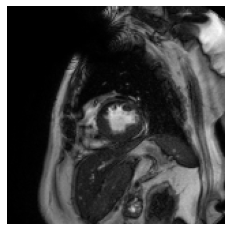

In [ ]:
#  Select random layer number
#maxval = 159
#i = np.random.randint(0, maxval)
#Define a channel to look at
#channel = 46
#print(f"Plotting Layer {i} Channel {channel} of Image")
#plt.imshow(trainx[:, :, i, channel], cmap='gray')
#plt.axis('off');

#plt.figure()
#plt.imshow(trainx[0,0,:,:], cmap='gray')
#zeroth = trainx[0,0,:,:]
#print('zero shape', zeroth.shape)

# DISPLAYING IMAGES
fifteenth_B = trainx[15,0,:,:]

np.resize(fifteenth_B,(160,160))

plt.figure()
plt.imshow(fifteenth_B, cmap='gray')
plt.axis('off')
plt.savefig('fifteenth_B.jpeg')
print(fifteenth_B.shape)


#plt.figure()
#plt.imshow(trainx[1000,0,:,:], cmap='gray')

#plt.figure()
#plt.imshow(trainx[2000,0,:,:], cmap='gray')

In [ ]:
print(type(fifteenth_B))

<class 'numpy.ndarray'>


(-0.5, 159.5, 159.5, -0.5)

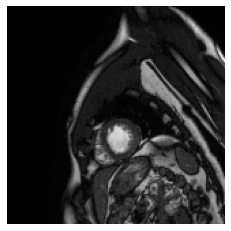

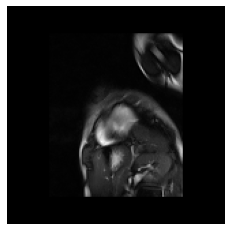

In [ ]:
fifty_B = trainx[50,0,:,:]
np.resize(fifty_B,(160,160))
plt.figure()
plt.imshow(fifty_B, cmap='gray')
plt.axis('off')

fifty_A = trainx_A[50,0,:,:]
np.resize(fifty_A,(160,160))
plt.figure()
plt.imshow(fifty_A, cmap='gray')
plt.axis('off')

(160, 160)
(160, 160)


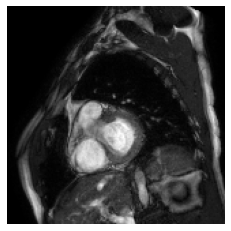

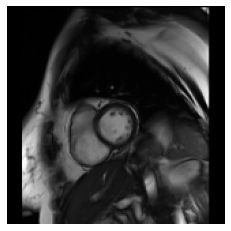

In [ ]:
eighty_two_B = trainx[82,0,:,:]
np.resize(eighty_two_B,(160,160))
plt.figure()
plt.imshow(eighty_two_B, cmap='gray')
plt.axis('off')

eighty_two_A = trainx_A[82,0,:,:]
np.resize(eighty_two_A,(160,160))
plt.figure()
plt.imshow(eighty_two_A, cmap='gray')
plt.axis('off')

plt.savefig('eighty_two_B.jpeg')
print(eighty_two_B.shape)

plt.savefig('eighty_two_A.jpeg')
print(eighty_two_A.shape)


(160, 160)
(160, 160)


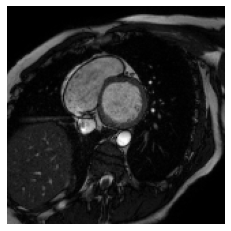

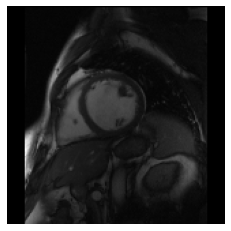

In [ ]:
one_twenty_B = trainx[120,0,:,:]
np.resize(one_twenty_B,(160,160))
plt.figure()
plt.imshow(one_twenty_B, cmap='gray')
plt.axis('off')

one_twenty_A = trainx_A[120,0,:,:]
np.resize(one_twenty_A,(160,160))
plt.figure()
plt.imshow(one_twenty_A, cmap='gray')
plt.axis('off')

plt.savefig('one_twenty_B.jpeg')
print(one_twenty_B.shape)

plt.savefig('one_twenty_A.jpeg')
print(one_twenty_A.shape)

(-0.5, 159.5, 159.5, -0.5)

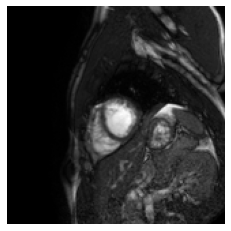

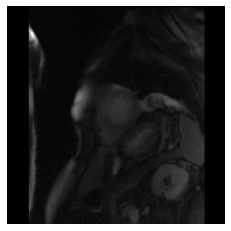

In [ ]:
one_forty_five_B = trainx[145,0,:,:]
np.resize(one_forty_five_B,(160,160))
plt.figure()
plt.imshow(one_forty_five_B, cmap='gray')
plt.axis('off')

one_forty_five_A = trainx_A[145,0,:,:]
np.resize(one_forty_five_A,(160,160))
plt.figure()
plt.imshow(one_forty_five_A, cmap='gray')
plt.axis('off')


(-0.5, 159.5, 159.5, -0.5)

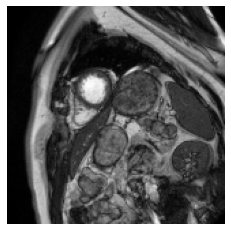

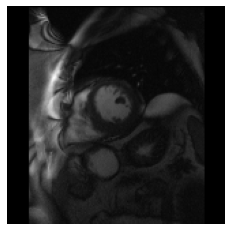

In [ ]:
two_thirty_eight_B = trainx[238,0,:,:]
np.resize(two_thirty_eight_B,(160,160))
plt.figure()
plt.imshow(two_thirty_eight_B, cmap='gray')
plt.axis('off')

two_thirty_eight_A = trainx_A[238,0,:,:]
np.resize(two_thirty_eight_A,(160,160))
plt.figure()
plt.imshow(two_thirty_eight_A, cmap='gray')
plt.axis('off')


(160, 160)


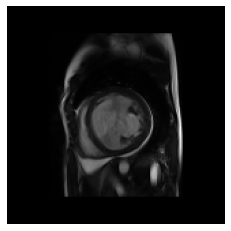

In [ ]:
# Displaying IMAGES 
fifteenth_A = trainx_A[15,0,:,:]

plt.figure()
plt.imshow(fifteenth_A, cmap='gray')
plt.axis('off')
print(fifteenth_A.shape)
plt.savefig('fifteenth_A.jpeg')

In [ ]:
# HISTOGRAM MATCHING 
 def histeq(im,nbr_bins=256):

   #get image histogram
   imhist,bins = histogram(im.flatten(),nbr_bins,normed=True)
   cdf = imhist.cumsum() #cumulative distribution function
   cdf = 255 * cdf / cdf[-1] #normalize

   #use linear interpolation of cdf to find new pixel values
   im2 = interp(im.flatten(),bins[:-1],cdf)

   return im2.reshape(im.shape), cdf

   

In [ ]:
#HISTOGRAM MATCHING
import PIL
from imageio import imsave, imread
import numpy as np

imsrc = imread("/content/gdrive/MyDrive/source_im/im_src1657.png")
imtint = imread("/content/gdrive/MyDrive/target_im/im_trg1897.png")

nbr_bins=255
if len(imsrc.shape) < 3:
    imsrc = imsrc[:,:,np.newaxis]
    imtint = imtint[:,:,np.newaxis]

imres = imsrc.copy()
for d in range(imsrc.shape[2]):
    imhist,bins = np.histogram(imsrc[:,:,d].flatten(),nbr_bins,normed=True)
    tinthist,bins = np.histogram(imtint[:,:,d].flatten(),nbr_bins,normed=True)

    cdfsrc = imhist.cumsum() #cumulative distribution function
    cdfsrc = (255 * cdfsrc / cdfsrc[-1]).astype(np.uint8) #normalize

    cdftint = tinthist.cumsum() #cumulative distribution function
    cdftint = (255 * cdftint / cdftint[-1]).astype(np.uint8) #normalize


    im2 = np.interp(imsrc[:,:,d].flatten(),bins[:-1],cdfsrc)



    im3 = np.interp(im2,cdftint, bins[:-1])

    imres[:,:,d] = im3.reshape((imsrc.shape[0],imsrc.shape[1] ))

try:
    imsave("histnormresult.jpg", imres)
except:
    imsave("histnormresult.jpg", imres.reshape((imsrc.shape[0],imsrc.shape[1] )))

Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


(160, 160)
(160, 160)


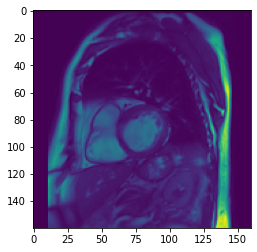

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import image
from skimage import data
from skimage import exposure
from skimage.exposure import match_histograms

#reference = '/content/gdrive/MyDrive/source_im'
#image = '/content/gdrive/MyDrive/target_im'

image_src = image.imread('/content/gdrive/MyDrive/source_im/im_src1607.png')
data_src = np.asarray(image_src)
image_ = data_src
print(data_src.shape)
plt.imshow(image_)

# create Pillow image
image_trg = Image.open('/content/gdrive/MyDrive/target_im/im_trg1541.png')
data_trg = np.asarray(image_trg)
reference = data_trg
print(reference.shape)



In [ ]:
# matched = match_histograms(image, reference, multichannel=True)

# fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
#                                     sharex=True, sharey=True)
# for aa in (ax1, ax2, ax3):
#     aa.set_axis_off()

# ax1.imshow(image)
# ax1.set_title('Source')
# ax2.imshow(reference)
# ax2.set_title('Reference')
# ax3.imshow(matched)
# ax3.set_title('Matched')

# plt.tight_layout()
# plt.show()

AttributeError: ignored

In [ ]:
# fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))


# for i, img in enumerate((image, reference, matched)):
#     for c, c_color in enumerate(('red', 'green', 'blue')):
#         img_hist, bins = exposure.histogram(img[..., c], source_range='dtype')
#         axes[c, i].plot(bins, img_hist / img_hist.max())
#         img_cdf, bins = exposure.cumulative_distribution(img[..., c])
#         axes[c, i].plot(bins, img_cdf)
#         axes[c, 0].set_ylabel(c_color)

# axes[0, 0].set_title('Source')
# axes[0, 1].set_title('Reference')
# axes[0, 2].set_title('Matched')

# plt.tight_layout()
# plt.show()

In [ ]:
# Had to use this function for calling the fourier transform function below
#def low_freq_mutate_np( amp_src, amp_trg, L=0.1 ):
#    a_src = np.fft.fftshift( amp_src, axes=(-2, -1) )
#    a_trg = np.fft.fftshift( amp_trg, axes=(-2, -1) )

#    _, h, w = a_src.shape
#    b = (  np.floor(np.amin((h,w))*L)  ).astype(int)
#    c_h = np.floor(h/2.0).astype(int)
#    c_w = np.floor(w/2.0).astype(int)

#    h1 = c_h-b
#    h2 = c_h+b+1
#    w1 = c_w-b
#    w2 = c_w+b+1

#    a_src[:,h1:h2,w1:w2] = a_trg[:,h1:h2,w1:w2]
#    a_src = np.fft.ifftshift( a_src, axes=(-2, -1) )
#    return a_src


In [ ]:
''' def FDA_source_to_target_np( src_img, trg_img, L=0.1 ):
    # exchange magnitude
    # input: src_img, trg_img

    src_img_np = src_img #.cpu().numpy()
    trg_img_np = trg_img #.cpu().numpy()

    # get fft of both source and target
    fft_src_np = np.fft.fft2( src_img_np, axes=(-2, -1) )
    fft_trg_np = np.fft.fft2( trg_img_np, axes=(-2, -1) )

    # extract amplitude and phase of both ffts
    amp_src, pha_src = np.abs(fft_src_np), np.angle(fft_src_np)
    amp_trg, pha_trg = np.abs(fft_trg_np), np.angle(fft_trg_np)

    # mutate the amplitude part of source with target
    amp_src_ = low_freq_mutate_np( amp_src, amp_trg, L=L )

    # mutated fft of source
    fft_src_ = amp_src_ * np.exp( 1j * pha_src )

    # get the mutated image
    src_in_trg = np.fft.ifft2( fft_src_, axes=(-2, -1) )
    src_in_trg = np.real(src_in_trg)

    return src_in_trg '''

In [ ]:
''' # Calling the fourier transform function 
# Used the code from the paper to call the fourier transform function but it gives error stating too many dimension 
import numpy as np
from PIL import Image
import scipy.misc
im_src = Image.open('/content/one_twenty_A.jpeg').convert('Gray')
im_trg = Image.open('/content/one_twenty_B.jpeg').convert('Gray')

im_src = im_src.resize( (1024,516), Image.BICUBIC )
im_trg = im_trg.resize( (1024,516), Image.BICUBIC )


im_src = np.asarray(im_src, np.float32)
im_trg = np.asarray(im_trg, np.float32)

im_src = im_src.transpose((2, 0, 1))
im_trg = im_trg.transpose((2, 0, 1))




src_in_trg = FDA_source_to_target_np( im_src, im_trg, L=0.5 )

print(src_in_trg.shape)
src_in_trg = src_in_trg.transpose((1,2,0))

print(src_in_trg.shape)

# Creates PIL image
img = Image.fromarray((src_in_trg).astype(np.uint8))
#img = Image.fromarray((src_in_trg))
img.show()
print(img)
plt.figure()
plt.imshow(img)
plt.axis('off')


#scipy.misc.toimage(src_in_trg, cmin=0.0, cmax=255.0).save('demo_images/src_in_tar.png') '''

Inside low_freq_mutate_np  (3, 516, 1024) (3, 516, 1024)


ValueError: ignored

In [ ]:
def low_freq_mutate_np( amp_src, amp_trg, L=0.1 ):
    print('Inside low_freq_mutate_np ', amp_src.shape, amp_trg.shape)
   
    a_src = np.fft.fftshift( amp_src)#, axes=(-2, -1) )
    a_trg = np.fft.fftshift( amp_trg)#, axes=(-2, -1) )

    #_, h, w = a_src.shape
    h, w = a_src.shape
    b    = (  np.floor(np.amin((h,w))*L)  ).astype(int)
    c_h  = np.floor(h/2.0).astype(int)
    c_w  = np.floor(w/2.0).astype(int)

    h1 = c_h-b
    h2 = c_h+b+1
    w1 = c_w-b
    w2 = c_w+b+1
   
    print('h1 h2 w1 and w2 are ', h1, h2, w1, w2, h, w, b)
    a_src[h1:h2,w1:w2] = a_trg[h1:h2,w1:w2]
    a_src = np.fft.ifftshift( a_src, axes=(-2, -1) )
    return a_src

def FDA_source_to_target_np( src_img, trg_img, L=0.1 ):
    # exchange magnitude
    # input: src_img, trg_img

    src_img_np = src_img #.cpu().numpy()
    trg_img_np = trg_img #.cpu().numpy()

    # get fft of both source and target
    fft_src_np = np.fft.fft2( src_img_np)#, axes=(-2, -1) )
    fft_trg_np = np.fft.fft2( trg_img_np)#, axes=(-2, -1) )

    # extract amplitude and phase of both ffts
    amp_src, pha_src = np.abs(fft_src_np), np.angle(fft_src_np)
    amp_trg, pha_trg = np.abs(fft_trg_np), np.angle(fft_trg_np)

    # mutate the amplitude part of source with target
    amp_src_ = low_freq_mutate_np( amp_src, amp_trg, L=L )

    # mutated fft of source
    fft_src_ = amp_src_ * np.exp( 1j * pha_src )
   
    print(fft_src_.shape, 'fft_src_ shape is ')
    # get the mutated image
    #src_in_trg = np.fft.ifft2( fft_src_, axes=(-2, -1) )
    src_in_trg = np.fft.ifft2( fft_src_)
    src_in_trg = np.real(src_in_trg)

    return src_in_trg


import numpy as np
from PIL import Image
#from utils import FDA_source_to_target_np
import scipy.misc

#im_src = Image.open("/home/yu-hao/Downloads/source.png").convert('gray')#.convert('RGB')
#im_trg = Image.open("/home/yu-hao/Downloads/target.png").convert('gray')#.convert('RGB')

from skimage import io
im_src = Image.fromarray(io.imread('/content/fifteenth_A.jpeg', as_gray=True))
im_trg = Image.fromarray(io.imread('/content/fifteenth_B.jpeg', as_gray=True))

#print(im_src, im_trg)

im_src = im_src.resize( (1024,512), Image.BICUBIC )
im_trg = im_trg.resize( (1024,512), Image.BICUBIC )

im_src = np.asarray(im_src, np.float32)
im_trg = np.asarray(im_trg, np.float32)

#im_src = im_src.transpose((2, 0, 1))
#im_trg = im_trg.transpose((2, 0, 1))


src_in_trg = FDA_source_to_target_np( im_src, im_trg, L=0.5 ).astype('float32')


print(im_src.shape, im_trg.shape, src_in_trg.shape, im_src.dtype, im_trg.dtype, src_in_trg.dtype)

#src_in_trg = src_in_trg.transpose((1,2,0))
#scipy.misc.toimage(src_in_trg, cmin=0.0, cmax=255.0).save('src_in_tar.png')
#from scipy.misc import imsave
import scipy.misc
#scipy.misc.imsave('outfile.jpg', image_array)
import imageio
imageio.imwrite('src_in_trg.png', src_in_trg)
imageio.imwrite('im_src.png', im_src)
imageio.imwrite('im_trg.png', im_trg)

#scipy.misc.imsave('gradient.png', src_in_trg)

Inside low_freq_mutate_np  (512, 1024) (512, 1024)
h1 h2 w1 and w2 are  0 513 256 769 512 1024 256
(512, 1024) fft_src_ shape is 
(512, 1024) (512, 1024) (512, 1024) float32 float32 float32


In [ ]:
one_twenty_B = trainx[120,0,:,:]
np.resize(one_twenty_B,(160,160))

one_twenty_A = trainx_A[120,0,:,:]
np.resize(one_twenty_A,(160,160))

im_src = np.asarray(one_twenty_A, np.float32)
im_trg = np.asarray(one_twenty_B, np.float32)

src_in_trg = FDA_source_to_target_np( im_src, im_trg, L=0.5 ).astype('float32')

print(im_src.shape, im_trg.shape, src_in_trg.shape, im_src.dtype, im_trg.dtype, src_in_trg.dtype)

import scipy.misc
import imageio
#imageio.imwrite('src_in_trg.png', src_in_trg)
#imageio.imwrite('im_src.png', im_src)
#imageio.imwrite('im_trg.png', im_trg)

Inside low_freq_mutate_np  (160, 160) (160, 160)
h1 h2 w1 and w2 are  0 161 0 161 160 160 80
(160, 160) fft_src_ shape is 
(160, 160) (160, 160) (160, 160) float32 float32 float32


In [ ]:
import scipy.misc
import imageio
print(trainx.shape)
print(trainx.shape[0])
all_src_in_trg = []
all_src = []
all_trg = []
for x2 in range(trainx_A.shape[0]):
  #print(trainx[x,0,:,:])
  one_twenty_B = trainx[x2,0,:,:]
  np.resize(one_twenty_B,(160,160))

  one_twenty_A = trainx_A[x2,0,:,:]
  np.resize(one_twenty_A,(160,160))

  im_src = np.asarray(one_twenty_A, np.float32)
  im_trg = np.asarray(one_twenty_B, np.float32)

  src_in_trg = FDA_source_to_target_np( im_src, im_trg, L=0.5 ).astype('float32')

  all_src_in_trg.append(src_in_trg)
  all_src.append(im_src)
  all_trg.append(im_trg)
  print(x2,im_src.shape, im_trg.shape, src_in_trg.shape, im_src.dtype, im_trg.dtype, src_in_trg.dtype)
  #imageio.imwrite('im_src' + str(x) + '.png', im_src)
  #imageio.imwrite('im_trg' + str(x) + '.png', im_trg)
  #imageio.imwrite('/content/transformed_data/src_in_trg' + str(x2) + '.png', src_in_trg)
  #imageio.imwrite('/content/source_im/im_src' + str(x2) + '.png', im_src)
  #imageio.imwrite('/content/target_im/im_trg' + str(x2) + '.png', im_trg)
all_src_in_trg = np.asarray(all_src_in_trg) 
all_src = np.asarray(all_src)
all_trg = np.asarray(all_trg)
print(all_src.shape)
print(all_trg.shape)
print(all_src_in_trg.shape) 
reshape_all_src = np.expand_dims(all_src,1)
print(reshape_all_src.shape)
reshape_all_trg = np.expand_dims(all_trg,1)
print(reshape_all_trg.shape)
reshape_all_src_in_trg = np.expand_dims(all_src_in_trg,1)
print(reshape_all_src_in_trg.shape)
#print(reshape_all_src_in_trg)

Streaming output truncated to the last 5000 lines.
(160, 160) fft_src_ shape is 
1259 (160, 160) (160, 160) (160, 160) float32 float32 float32
Inside low_freq_mutate_np  (160, 160) (160, 160)
h1 h2 w1 and w2 are  0 161 0 161 160 160 80
(160, 160) fft_src_ shape is 
1260 (160, 160) (160, 160) (160, 160) float32 float32 float32
Inside low_freq_mutate_np  (160, 160) (160, 160)
h1 h2 w1 and w2 are  0 161 0 161 160 160 80
(160, 160) fft_src_ shape is 
1261 (160, 160) (160, 160) (160, 160) float32 float32 float32
Inside low_freq_mutate_np  (160, 160) (160, 160)
h1 h2 w1 and w2 are  0 161 0 161 160 160 80
(160, 160) fft_src_ shape is 
1262 (160, 160) (160, 160) (160, 160) float32 float32 float32
Inside low_freq_mutate_np  (160, 160) (160, 160)
h1 h2 w1 and w2 are  0 161 0 161 160 160 80
(160, 160) fft_src_ shape is 
1263 (160, 160) (160, 160) (160, 160) float32 float32 float32
Inside low_freq_mutate_np  (160, 160) (160, 160)
h1 h2 w1 and w2 are  0 161 0 161 160 160 80
(160, 160) fft_src_ shap

In [ ]:
print(all_src.shape)
print(all_trg.shape)
print(all_src_in_trg.shape) 

print(reshape_all_src_in_trg.shape)
print(reshape_all_src.shape)
print(reshape_all_trg.shape)

(2508, 160, 160)
(2508, 160, 160)
(2508, 160, 160)
(2508, 1, 160, 160)
(2508, 1, 160, 160)
(2508, 1, 160, 160)


In [ ]:
import random
new_set = np.concatenate((trainx_A, reshape_all_src_in_trg), axis=0)
random.seed(2)
random.shuffle(new_set)
print(new_set.shape)
print(trainx_A.shape)
print(reshape_all_src_in_trg.shape)

(5016, 1, 160, 160)
(2508, 1, 160, 160)
(2508, 1, 160, 160)


In [ ]:
new_trainy_A = np.resize(trainy_A,(5016,1,160,160))
print(new_trainy_A.shape)

(5016, 1, 160, 160)


In [ ]:
# For trainng the Model for segmentation
# [STAR] For training Single U-Net pytorch in a loop

import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp


def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)
    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)
    return 2. * intersection.sum() / (im1.sum() + im2.sum()+0.00001)

def dice_loss(pred, target, smooth = 1.):
    pred = F.sigmoid(pred)
    
    pred   = pred.contiguous()
    target = target.contiguous()    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()

# basepath       = '/media/yu-hao/WindowsData/COVID_MOSCOW/COVID_MOSCOW/COVID19_1110/'
# train_ids      = np.load(basepath+'TRAIN.npy')
# val_ids        = np.load(basepath+'VALIDATION.npy')
# test_ids       = np.load(basepath+'TEST.npy')
# unlabelled_ids = np.load(basepath+'NOTLABELLED.npy')

# train_ids      = train_ids[:4]
# trainx, trainy = read_training_data(train_ids)
# valx, valy     = read_training_data(val_ids)
# testx, testy   = read_training_data(test_ids)

basepath = '/content/gdrive/MyDrive/MandM1'

modelname = 0


model = SUNet(1, 4)
model.cuda()
    
if modelname == 0:
  print('adc')
    #basepath+"models/unet_A_"+str(modelname)+".pt"
    #p1 = torch.load(basepath+"models/unet_A_"+str(modelname)+".pt")
    #model.load_state_dict(p1)
#p1 = torch.load('/media/dril/New Volume/COVID_MOSCOW/unet_6.pt')
#model.load_state_dict(p1)

device    = torch.device("cuda:0")
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss(torch.ones([1]).cuda())
prev_min  = -1
    
train_loss_array = []
val_loss_array   = []

train_dice_array = []
val_dice_array   = []
    
for epoch in range(30):
    model.train()
    loss_array = []

    train_y_true = []
    train_y_pred = []

    #print('training')
    batch_size = 4
    for i in range(len(new_set)//batch_size):
        x = new_set[i*batch_size:(i+1)*batch_size, :, :, :]
        y = new_trainy_A[i*batch_size:(i+1)*batch_size, 0, :, :]
        #y = trainy[i*batch_size:(i+1)*batch_size, :, :, :]

        for k in range(x.shape[0]):
            rotv = random.randint(0, 3)
            x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)#rotate(x[k, 0, :, :], angle=angle, mode = 'wrap')
            y[k, :, :] = np.rot90(y[k, :, :], rotv)#rotate(y[k, 0, :, :], angle=angle, mode = 'wrap')

        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).long()
        #y = torch.tensor(y, device=device).float()

        optimizer.zero_grad()
        output = model.forward(x)
        
        loss = criterion(output , y)
        loss.backward()
        loss_array.append(loss.item())
        optimizer.step()
        
        output = F.log_softmax(output, dim=1)
        #output = torch.nn.LogSoftmax(output)
        output = np.argmax(output.data.cpu().numpy(), 1)
        #output = output.data.cpu().numpy()
        y      = y.data.cpu().numpy()
        
        #output[output < 0.5] = 0
        #output[output > 0.5] = 1

        for pk in range(output.shape[0]):
            train_dice_array.append(dice(y[pk, :, :], output[pk, :, :]))
    
    train_loss = np.mean(loss_array)

    model.eval()

    val_y_true   = []
    val_y_pred   = []

    loss_array_val = []
    batch_size     = 1
    for ik in range(len(valx_A)//batch_size):
        x = valx_A[ik*batch_size:(ik+1)*batch_size, :, :, :]
        y = valy_A[ik*batch_size:(ik+1)*batch_size, 0, :, :]
        #y = valy[ik*batch_size:(ik+1)*batch_size, :, :, :]

        x = torch.tensor(x, device=device).float()
        #y = torch.tensor(y, device=device).float()
        y = torch.tensor(y, device=device).long()

        output = model.forward(x)
        #output = 
        loss   = criterion(output , y)#torch.max(y, 1)[1])
        loss_array_val.append(loss.item())
        #torch.nn.LogSoftmax

        output = F.log_softmax(output, dim=1)
        #output = torch.nn.LogSoftmax(output)
        #output = torch.sigmoid(output)
        #output = output.data.cpu().numpy()
        #y      = y.data.cpu().numpy()

        #output = output.data.cpu().numpy()
        output = np.argmax(output.data.cpu().numpy(), 1)
        y      = y.data.cpu().numpy()

        #output[output < 0.5] = 0
        #output[output > 0.5] = 1

        for pk in range(output.shape[0]):
            val_dice_array.append(dice(y[pk, :, :], output[pk, :, :]))

        for k in output:
            val_y_pred.append(k[0])
        for k in y:
            val_y_true.append(k[0])

    val_y_true = np.array(val_y_true)#.astype('uint8')
    val_y_pred = np.array(val_y_pred)#.astype('uint8')

    val_loss = np.mean(loss_array_val)
    print("Epoch %d -> Train loss %.5f, Val Loss %.5f Train Dice %.5f, Val Dice %.5f" % (epoch, train_loss, val_loss, np.mean(train_dice_array), np.mean(val_dice_array)))

    train_loss_array.append(train_loss)
    val_loss_array.append(val_loss)

    if np.mean(val_dice_array) > prev_min:
        print('Saving Model ', np.mean(val_dice_array), prev_min)
        prev_min = np.mean(val_dice_array)
        torch.save(model.state_dict(), str(modelname)+".pt")
        #if epoch == 0:
        #    temp1_img = sitk.GetImageFromArray(val_y_true)
        #    sitk.WriteImage(temp1_img, basepath+'models/true_new_'+str(modelname)+'_'+str(epoch)+'.nii.gz')
        

adc
Epoch 0 -> Train loss 0.17919, Val Loss 0.17299 Train Dice 0.25328, Val Dice 0.51338
Saving Model  0.5133828045445651 -1
Epoch 1 -> Train loss 0.14544, Val Loss 0.16658 Train Dice 0.35043, Val Dice 0.51063
Epoch 2 -> Train loss 0.14412, Val Loss 0.16329 Train Dice 0.38207, Val Dice 0.51187
Epoch 3 -> Train loss 0.14318, Val Loss 0.15951 Train Dice 0.39860, Val Dice 0.51312
Epoch 4 -> Train loss 0.14247, Val Loss 0.15860 Train Dice 0.40858, Val Dice 0.50851
Epoch 5 -> Train loss 0.14200, Val Loss 0.15645 Train Dice 0.41510, Val Dice 0.50631
Epoch 6 -> Train loss 0.14232, Val Loss 0.15626 Train Dice 0.41923, Val Dice 0.50447
Epoch 7 -> Train loss 0.14166, Val Loss 0.15511 Train Dice 0.42317, Val Dice 0.50320
Epoch 8 -> Train loss 0.14142, Val Loss 0.15394 Train Dice 0.42632, Val Dice 0.50282
Epoch 9 -> Train loss 0.14122, Val Loss 0.15129 Train Dice 0.42889, Val Dice 0.50197
Epoch 10 -> Train loss 0.14127, Val Loss 0.14999 Train Dice 0.43092, Val Dice 0.50106
Epoch 11 -> Train loss 0

In [ ]:
# For trainng the Model for segmentation
# TRAIN A and VAL B
# [STAR] For training Single U-Net pytorch in a loop

import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp


def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)
    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)
    return 2. * intersection.sum() / (im1.sum() + im2.sum()+0.00001)

def dice_loss(pred, target, smooth = 1.):
    pred = F.sigmoid(pred)
    
    pred   = pred.contiguous()
    target = target.contiguous()    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()

# basepath       = '/media/yu-hao/WindowsData/COVID_MOSCOW/COVID_MOSCOW/COVID19_1110/'
# train_ids      = np.load(basepath+'TRAIN.npy')
# val_ids        = np.load(basepath+'VALIDATION.npy')
# test_ids       = np.load(basepath+'TEST.npy')
# unlabelled_ids = np.load(basepath+'NOTLABELLED.npy')

# train_ids      = train_ids[:4]
# trainx, trainy = read_training_data(train_ids)
# valx, valy     = read_training_data(val_ids)
# testx, testy   = read_training_data(test_ids)

basepath = '/content/gdrive/MyDrive/MandM1'

modelname = 1


model = SUNet(1, 4)
model.cuda()
    
if modelname == 1:
  print('adc')
    #basepath+"models/unet_A_"+str(modelname)+".pt"
    #p1 = torch.load(basepath+"models/unet_A_"+str(modelname)+".pt")
    #model.load_state_dict(p1)
#p1 = torch.load('/media/dril/New Volume/COVID_MOSCOW/unet_6.pt')
#model.load_state_dict(p1)

device    = torch.device("cuda:0")
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss(torch.ones([1]).cuda())
prev_min  = -1
    
train_loss_array = []
val_loss_array   = []

train_dice_array = []
val_dice_array   = []
    
for epoch in range(30):
    model.train()
    loss_array = []

    train_y_true = []
    train_y_pred = []

    #print('training')
    batch_size = 4
    for i in range(len(trainx_new_set)//batch_size):
        x = trainx_new_set[i*batch_size:(i+1)*batch_size, :, :, :]
        y = trainy_new_set[i*batch_size:(i+1)*batch_size, 0, :, :]
        #y = trainy[i*batch_size:(i+1)*batch_size, :, :, :]

        for k in range(x.shape[0]):
            rotv = random.randint(0, 3)
            x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)#rotate(x[k, 0, :, :], angle=angle, mode = 'wrap')
            y[k, :, :] = np.rot90(y[k, :, :], rotv)#rotate(y[k, 0, :, :], angle=angle, mode = 'wrap')

        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).long()
        #y = torch.tensor(y, device=device).float()

        optimizer.zero_grad()
        output = model.forward(x)
        
        loss = criterion(output , y)
        loss.backward()
        loss_array.append(loss.item())
        optimizer.step()
        
        output = F.log_softmax(output, dim=1)
        #output = torch.nn.LogSoftmax(output)
        output = np.argmax(output.data.cpu().numpy(), 1)
        #output = output.data.cpu().numpy()
        y      = y.data.cpu().numpy()
        
        #output[output < 0.5] = 0
        #output[output > 0.5] = 1

        for pk in range(output.shape[0]):
            train_dice_array.append(dice(y[pk, :, :], output[pk, :, :]))
    
    train_loss = np.mean(loss_array)

    model.eval()

    val_y_true   = []
    val_y_pred   = []

    loss_array_val = []
    batch_size     = 1
    for ik in range(len(valx_A)//batch_size):
        x = valx_A[ik*batch_size:(ik+1)*batch_size, :, :, :]
        y = valy_A[ik*batch_size:(ik+1)*batch_size, 0, :, :]
        #y = valy[ik*batch_size:(ik+1)*batch_size, :, :, :]

        x = torch.tensor(x, device=device).float()
        #y = torch.tensor(y, device=device).float()
        y = torch.tensor(y, device=device).long()

        output = model.forward(x)
        #output = 
        loss   = criterion(output , y)#torch.max(y, 1)[1])
        loss_array_val.append(loss.item())
        #torch.nn.LogSoftmax

        output = F.log_softmax(output, dim=1)
        #output = torch.nn.LogSoftmax(output)
        #output = torch.sigmoid(output)
        #output = output.data.cpu().numpy()
        #y      = y.data.cpu().numpy()

        #output = output.data.cpu().numpy()
        output = np.argmax(output.data.cpu().numpy(), 1)
        y      = y.data.cpu().numpy()

        #output[output < 0.5] = 0
        #output[output > 0.5] = 1

        for pk in range(output.shape[0]):
            val_dice_array.append(dice(y[pk, :, :], output[pk, :, :]))

        for k in output:
            val_y_pred.append(k[0])
        for k in y:
            val_y_true.append(k[0])

    val_y_true = np.array(val_y_true)#.astype('uint8')
    val_y_pred = np.array(val_y_pred)#.astype('uint8')

    val_loss = np.mean(loss_array_val)
    print("Epoch %d -> Train loss %.5f, Val Loss %.5f Train Dice %.5f, Val Dice %.5f" % (epoch, train_loss, val_loss, np.mean(train_dice_array), np.mean(val_dice_array)))

    train_loss_array.append(train_loss)
    val_loss_array.append(val_loss)

    if np.mean(val_dice_array) > prev_min:
        print('Saving Model ', np.mean(val_dice_array), prev_min)
        prev_min = np.mean(val_dice_array)
        torch.save(model.state_dict(), str(modelname)+".pt")
        #if epoch == 0:
        #    temp1_img = sitk.GetImageFromArray(val_y_true)
        #    sitk.WriteImage(temp1_img, basepath+'models/true_new_'+str(modelname)+'_'+str(epoch)+'.nii.gz')

adc


RuntimeError: ignored

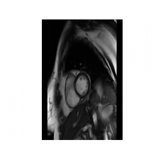

In [ ]:

import numpy as np
from PIL import Image

import scipy.misc

im_src = Image.open("/content/eighty_two_A.jpeg").convert('RGB')
im_trg = Image.open("/content/eighty_two_B.jpeg").convert('RGB')

im_src = im_src.resize( (160,160), Image.BICUBIC )
im_trg = im_trg.resize( (160,160), Image.BICUBIC )

im_src = np.asarray(im_src, np.float32)
im_trg = np.asarray(im_trg, np.float32)

im_src = im_src.transpose((2, 0, 1))
im_trg = im_trg.transpose((2, 0, 1))

src_in_trg = FDA_source_to_target_np( im_src, im_trg, L=0.01 )

src_in_trg = src_in_trg.transpose((1,2,0))
#scipy.misc.toimage(src_in_trg, cmin=0.0, cmax=255.0).save('/src_in_tar.png')
Image.fromarray((src_in_trg).astype(np.uint8))


In [ ]:
# I tried with simply passing the two images in the fourier function but that to gives an error 

im_src = Image.open('/content/fifteen_A.png')
im_trg = Image.open('/content/fifteen_B.png')

src_in_trg = FDA_source_to_target_np( im_src, im_trg, L=0.01 )



In [ ]:
# Also tried this but gives an error 
im_src = fifteenth_A # (fifteenth_A = trainx_A[15,0,:,:])
im_trg = fifteenth_B # (fifteenth_B = trainx[15,0,:,:])
src_in_trg = FDA_source_to_target_np( im_src, im_trg, L=0.01 )

ValueError: ignored